> ## **Métodos Computacionales II - Taller #1**

**Hecho por:** Thomas Andrade Hernández (202214695) & Juan Carlos Rojas V. (202214037)

In [80]:
# Zona de librerías:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import random as rnd
import math as math
import scipy as sci

> **Sección 2.9:**

**1.** Muestre que los siguientes operadores diferenciales:

$$f'(x) = \frac{-f(x + 2h) + 4f(x + h) - 3f(x)}{2h}$$

$$f''(x) = \frac{f(x + h) - 2f(x) + f(x - h)}{h^{2}}$$

son consistentes. Use como funciones de prueba $f(x) = x^{2}$ y $f(x) = sin(x)$.

> **Solución:**

Para empezar con la verificación de la consistencia de los operadores, se empleará la función $f(x) = x^2$. En el caso de la primera derivada se tiene:

$$f'(x) = \lim_{h \to 0} \frac{-(x + 2h)^{2} + 4(x + h)^{2} - 3x^{2}}{2h}$$

$$ = \lim_{h \to 0} \frac{-x^{2} - 4xh - 4h^{2} + 4x^{2} + 8xh + h^{2} - 3x^{2}}{2h}$$

$$ = \lim_{h \to 0} \frac{4xh - 3h^{2}}{2h} = \lim_{h \to 0} 4x + \frac{3}{2}h$$

$$ f'(x) = 2x $$

Este es el resultado esperado, lo que muestra consistencia. Por otro lado, la segunda derivada sería:

$$f''(x) = \lim_{h \to 0} \frac{(x + h)^{2} - 2x^{2} + (x - h)^{2}}{h^{2}}$$

$$ = \lim_{h \to 0} \frac{x^{2} + 2xh + h^{2} - 2x^{2} + x^{2} - 2xh + h^{2}}{h^{2}} = \lim_{h \to 0} \frac{2h^{2}}{h^{2}}$$

$$ f''(x) = 2 $$

Una vez más, el resultado esperado.

---

Por otra parte, al emplear la función $f(x) = \sin(x)$ se obtendría como resultado:

$$f'(x) = \lim_{h \to 0} \frac{-\sin(x + 2h) + \sin(x + h) - 3\sin(x)}{2h}$$

Empleando propiedades de suma de ángulos para el seno y agrupando términos:

$$ = \lim_{h \to 0} \frac{-\sin(x)\cos(2h) - \cos(x)\sin(2h) + 4\sin(x)\cos(h) + 4\cos(x)\sin(h) - 3\sin(x)}{2h}$$

$$ = \lim_{h \to 0} \frac{\sin(x) \cdot (4\cos(h) - \cos(2h) - 3)}{2h} + \lim_{h \to 0} \frac{- \cos(x)\sin(2h) + 4\cos(x)\sin(h)}{2h}$$

El límite de la izquierda se halla mediante la regla de L'Hopital:

$$\lim_{h \to 0} \frac{\sin(x) \cdot (4\cos(h) - \cos(2h) - 3)}{2h} = \lim_{h \to 0} \frac{\sin(x) \cdot (-4\sin(h) + 2\sin(2h))}{2} = 0$$

El de la derecha solo necesita distribuir el denominador en ambos términos de la suma:

$$\lim_{h \to 0} -\frac{\cos(x)\sin(2h)}{2h} + \lim_{h \to 0}\frac{4\cos(x)\sin(h)}{2h} = 2\cos(x) - \cos(x) = \cos(x)$$

Por ende, la primera derivada resulta:

$$f'(x) = 0 + \cos(x) = \cos(x)$$

El resultado esperado. Por último, para la segunda derivada de ésta función se tiene:

$$f''(x) = \lim_{h \to 0} \frac{\sin(x + h) - 2\sin(x) + \sin(x - h)}{h^{2}}$$

$$ = \lim_{h \to 0} \frac{\sin(x)\cos(h) + \cos(x)\sin(h) - 2\sin(x) + \sin(x)\cos(h) - \cos(x)\sin(h)}{h^{2}}$$

$$ = \lim_{h \to 0} \frac{2\sin(x)\cos(h) - 2\sin(x)}{h^{2}} = \lim_{h \to 0} \frac{2\sin(x) \cdot (\cos(h) - 1)}{h^{2}}$$

Empleando L'Hopital:

$$\lim_{h \to 0} \frac{2\sin(x) \cdot (\cos(h) - 1)}{h^{2}} = \lim_{h \to 0} \frac{2\sin(x) \cdot (-\sin(h))}{2h} = -\sin(x)$$

Por ende, el valor de la segunda derivada de la función sería:

$$f''(x) = -\sin(x)$$

El valor esperado.

***

**2.** Usando el código de la clase, genere 10 esferas localizadas aleatoriamente en la mesa A = 40 × 40 con velocidad aleatorias entre $−5$ m/s y $5$ m/s. Simule $10$ s con un paso de integración de $h = 0.001$ s y reduzca la simulación en un factor de 200; quitando la interacción con la pared. Conteste las siguientes preguntas exponiendo los conceptos físicos involucrados.

**a. & b.** Grafique el momento lineal total en $x$ ($p_x$) y $y$ ($p_y$) en función del tiempo. ¿Se deberían conservar?

In [81]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        # Atributos instantaneos:
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.pe = 0.
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        self.f = self.m*self.a
        
        # Historial:
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        self.P = np.zeros_like(self.R)
    
        # Física:
        
        self.K = 20.
        self.KE = np.zeros(len(t))
        self.PE = np.zeros(len(t))
        
    def Evolution(self,i):
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        self.SetPotentialEnergy(i)
        
        # Algoritmo de Euler:
#        self.r += self.dt*self.v
#        self.v += self.dt*self.a
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            Fn = self.K * compresion**3
            self.n = (self.r - p.r)/d
            self.f = np.add(self.f, Fn*self.n)
            self.pe += (self.K/4)*(compresion**4)
    
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        self.pe = 0.
        
    # Setter:
    
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.KE[i] = 0.5*self.m*np.dot(self.v,self.v)
        self.PE[i] = self.pe
        
    def SetPotentialEnergy(self,i):
        self.PE[i] = self.pe

    # Getter:
    
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.KE[::scale] 
    
    def GetPotentialEnergy(self,scale=1):
        return self.PE[::scale]

In [82]:
def GetParticles(N,t):
    
    Particles = []

    for i in range(N):
        r0 = np.array([float(rnd.randrange(-15,15)), float(rnd.randrange(-15,15))])
        v0 = np.array([float(rnd.randrange(-5,5)), float(rnd.randrange(-5,5))])
        a0 = np.array([0.,0.])
        Particles.append(Particle(r0,v0,a0,t))
    
    return Particles

In [83]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [84]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Trust me. Let me cook', unit=' Steps'):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j]) 
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            
            
    return Particles

In [85]:
Particles = RunSimulation(t,Particles)
number = len(Particles) - 1

Trust me. Let me cook: 100%|███████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1701.45 Steps/s]


In [86]:
scale = 200
t_ = t[::scale]

<IPython.core.display.Javascript object>


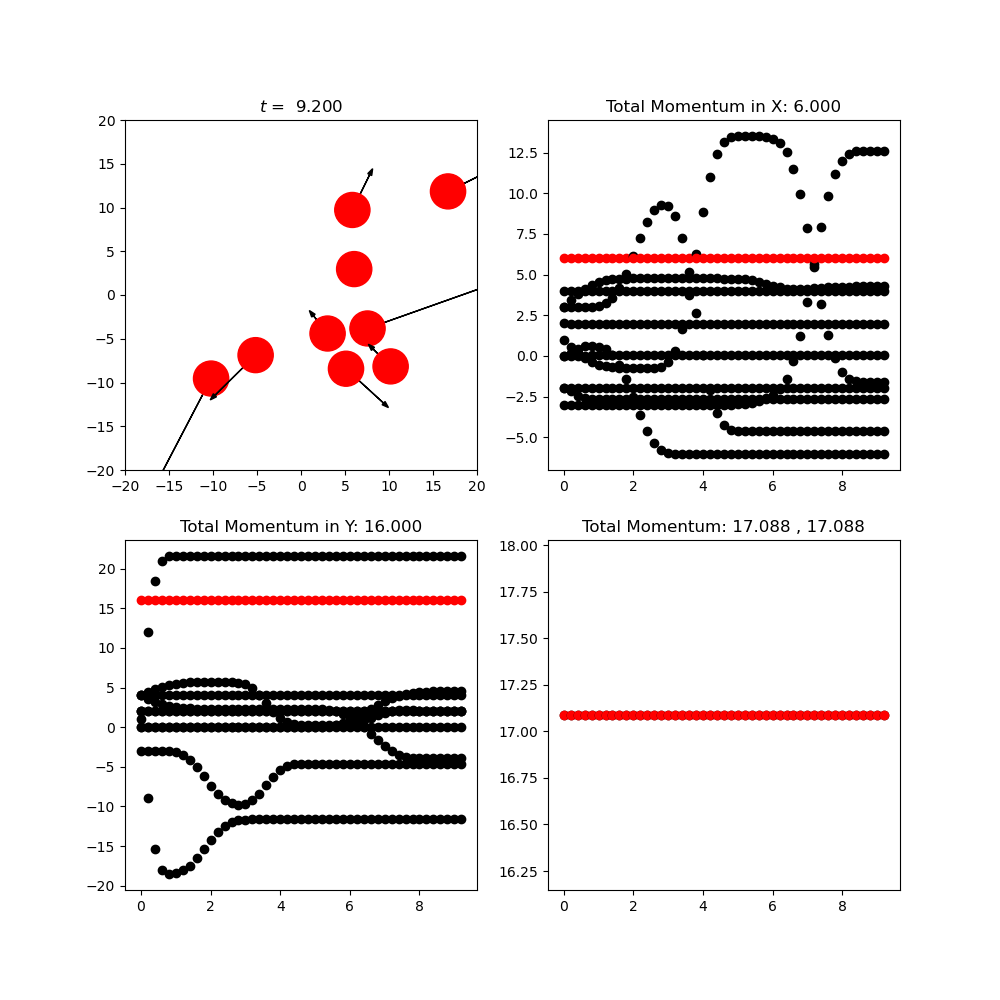

In [87]:
figP = plt.figure(figsize=(10,10))
axP = figP.add_subplot(221)
axP1 = figP.add_subplot(222)
axP2 = figP.add_subplot(223)
axP3 = figP.add_subplot(224)

def initP():
    axP.clear()
    axP.set_xlim(-20,20)
    axP.set_ylim(-20,20)
    
def UpdateMomentum(i):
    initP()
    axP.set_title(r'$t$ =  %.3f' %(t_[i]))
    px = 0.
    py = 0.
    p = 0.
    
    for j in range(0, len(Particles)):
        
        mass = Particles[j].m
        x = Particles[j].GetPosition(scale)[i,0]
        y = Particles[j].GetPosition(scale)[i,1]
        
        vx = Particles[j].GetVelocity(scale)[i,0]
        vy = Particles[j].GetVelocity(scale)[i,1]
        
        v = Particles[j].GetVelocity(scale)[i]
        
        axP.arrow(x,y,vx,vy,color='k',head_width=0.5) # Se ve más bonito con la flecha dentro del círculo. :3
        circle = plt.Circle( (x,y), Particles[j].radius, color='r', fill= True)
        axP.add_patch(circle)
        
        
        px_ = mass*vx
        py_ = mass*vy
        px += mass*vx
        py += mass*vy
        p += mass*v
        
        axP1.set_title(r'Total Momentum in X: {:.3f}'.format(px))
        axP1.scatter(t_[i], px_, color = "black")
        
        axP2.set_title(r'Total Momentum in Y: {:.3f}'.format(py))
        axP2.scatter(t_[i], py_, color = "black")
        
        if j == number:
            p = np.round(np.linalg.norm(p), 3)
            p_ = np.round(np.sqrt(px**2 + py**2), 3)
            axP1.scatter(t_[i], px, color = "red")
            axP2.scatter(t_[i], py, color = "red")
            
            axP3.set_title(r'Total Momentum: {} , {}'.format(p, p_))
            axP3.scatter(t_[i], p_, color = "black")
            axP3.scatter(t_[i], p, color = "red")
            
            
AnimationP = anim.FuncAnimation(figP,UpdateMomentum,frames=len(t_),init_func=initP, repeat = False)

Como se puede apreciar en la parte superior, el momento total en las coordenadas $x$ y $y$ de las partículas de la simulación resulta conservarse. Recordemos que el momento es una cantidad que se conserva en colisiones elásticas, mismas que sufren las partículas que nos encontramos estudiando. Por lo anterior, dado que el momento total se conserva, las coordenadas $x$ y $y$ también deberían de cumplir con dicha conservación, tal y como se observa en la animación superior.

**d. & e. & f.** Grafique los valores obtenidos para la energía potencial, cinética y mecánica. Explique los resultados obtenidos a nivel físico y a nivel método de Euler.

<IPython.core.display.Javascript object>


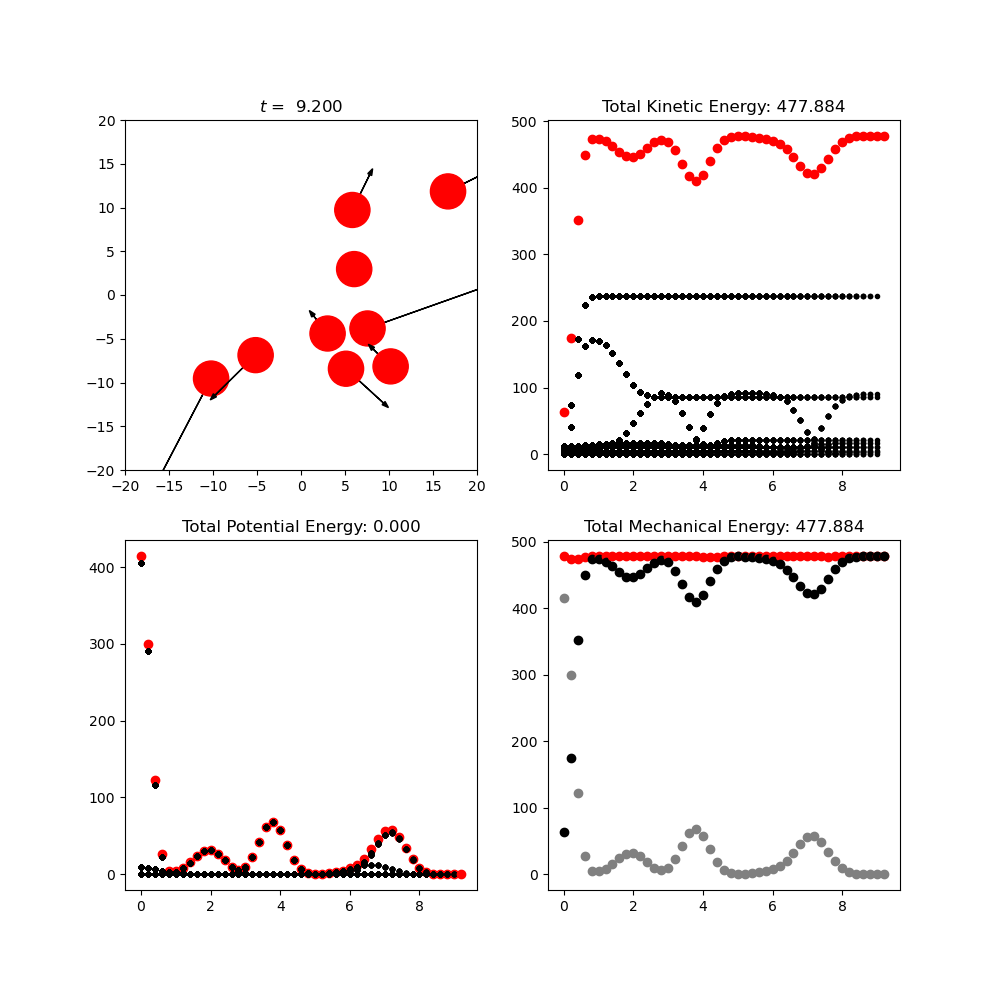

In [88]:
figE = plt.figure(figsize=(10,10))
axE = figE.add_subplot(221)
axE1 = figE.add_subplot(222)
axE2 = figE.add_subplot(223)
axE3 = figE.add_subplot(224)

def initE():
    axE.clear()
    axE.set_xlim(-20,20)
    axE.set_ylim(-20,20)
    
def UpdateEnergy(i):
    initE()
    axE.set_title(r'$t$ =  %.3f' %(t_[i]))
    KE = 0.
    PE = 0.
    
    for j in range(0, len(Particles)):
        
        x = Particles[j].GetPosition(scale)[i,0]
        y = Particles[j].GetPosition(scale)[i,1]
        
        vx = Particles[j].GetVelocity(scale)[i,0]
        vy = Particles[j].GetVelocity(scale)[i,1]
        
        axE.arrow(x,y,vx,vy,color='k',head_width=0.5) # Se ve más bonito con la flecha dentro del círculo. :3
        circle = plt.Circle( (x,y), Particles[j].radius, color='r', fill= True)
        axE.add_patch(circle)
        
        KE += Particles[j].GetKineticEnergy(scale)[i]
        PE += Particles[j].GetPotentialEnergy(scale)[i]
        
        axE1.set_title(r'Total Kinetic Energy: {:.3f}'.format(KE))
        axE1.scatter(t_[:i], Particles[j].GetKineticEnergy(scale)[:i],color='k',marker='.')
        
        axE2.set_title(r'Total Potential Energy: {:.3f}'.format(PE))
        axE2.scatter(t_[:i], Particles[j].GetPotentialEnergy(scale)[:i],color='k',marker='.')
        
        if j == number:
            axE1.scatter(t_[i], KE, color = "red")
            axE2.scatter(t_[i], PE/2, color = "red")
            axE3.scatter(t_[i], KE + PE/2, color = "red", label = "Mechanical Energy")
            axE3.scatter(t_[i], PE/2, color = "grey", label = "Potential Energy")
            axE3.scatter(t_[i], KE, color = "black", label = "Kinetic Energy")
            axE3.set_title(r'Total Mechanical Energy: {:.3f}'.format(PE/2 + KE))
    
AnimationE = anim.FuncAnimation(figE,UpdateEnergy,frames=len(t_),init_func=initE, repeat = False)

Como se puede apreciar en la parte superior, los valores de las energías cinética y potencial no se conservan a lo largo del tiempo. Este resultado es totalmente esperado dado que el asignar posiciones y velocidades aleatorias en el momento inicial permite la aparición de colisiones entre dos o más partículas, provocando así una reducción momentanea de la energía cinética en forma de energía potencial. 

Por otro lado, el valor base de la energía mecánica se conserva. Una forma física de ver ésto se obtiene de dos propiedades de este sistema: **1)** el sistema es totalmente cerrado, no existen fenómenos exteriores que puedan reducir o incrementar la energía inicial del sistema; y **2)** la base de las colisiones es totalmente ideal, de esta manera no se tiene pérdida de masa u otras propiedades producto del choque, lo que apoya la conservación de esta propiedad.


**NOTA:** A continuación se muestra un código que describe, de manera de compilación, cada una de las gráficas para el momento lineal y las energías. En cada una de ellas se apreciar la tendencia de conservación de éstas cantidades físicas.

In [89]:
Momentum = Particles[0].GetMomentum(scale)
Kinetic = Particles[0].GetKineticEnergy(scale)
Potential = Particles[0].GetPotentialEnergy(scale)

In [90]:
for i in range(1,len(Particles)):
    Momentum = np.add(Momentum,Particles[i].GetMomentum(scale))
    Kinetic = np.add(Kinetic,Particles[i].GetKineticEnergy(scale))
    Potential = np.add(Potential,Particles[i].GetPotentialEnergy(scale))

<IPython.core.display.Javascript object>


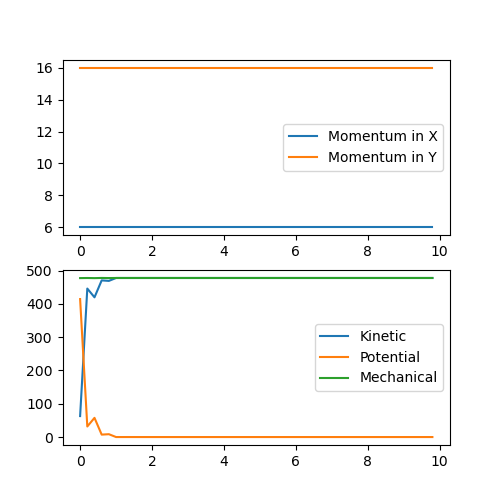

In [91]:
figME = plt.figure(figsize=(5,5))
axME1 = figME.add_subplot(211)
axME2 = figME.add_subplot(212)

axME1.plot(t_, Momentum[:,0], label='Momentum in X')
axME1.plot(t_, Momentum[:,1], label='Momentum in Y')
axME2.plot(t_, Kinetic, label='Kinetic')
axME2.plot(t_, 0.5*Potential, label='Potential')
axME2.plot(t_, Kinetic + 0.5*Potential,label='Mechanical')
axME1.legend()
axME2.legend()

**g.** ¿Se cumple el teorema del trabajo y la energía en su simulación? Argumente.

Recordemos que el teorema del trabajo-energía consiste en que el trabajo realizado sobre una partícula es igual al cambio de su energía cinética. Este teorema se puede observar en los valles de la energía cinética y los picos de la energía potencial. En cada escenario de colisión, el sistema transforma su energía cinética en potencial, que es lo mismo que el trabajo realizado sobre las partículas al chocar unas con otras.


**h.** Calcule y grafique el momento angular en el eje $z$ ($L_z$). ¿Se conserva?

Como se puede apreciar a continuación, la gráfica del momento angular $L_z$ en función del tiempo se mantiene en una recta centrada en un punto $y_0$, donde la solución oscila debido a los errores asociados al método de Euler-Cromer.

In [92]:
Angular = np.cross(Particles[0].GetPosition(scale), Particles[0].GetMomentum(scale))
for i in range(1,len(Particles)):
    Angular = np.add(Angular, np.cross(Particles[i].GetPosition(scale), Particles[i].GetMomentum(scale)))

<IPython.core.display.Javascript object>


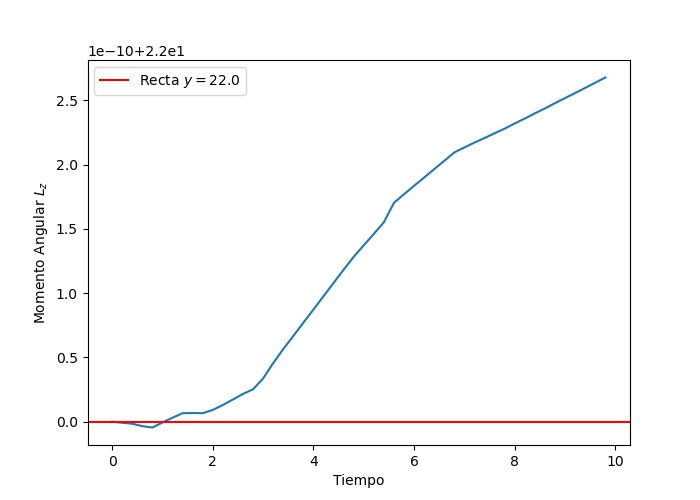

In [93]:
figAG = plt.figure(figsize = (7,5))
referee = np.round(Angular[0], 3)

plt.sylabel("Momento Angular $L_{z}$")
plt.xlabel("Tiempo")
plt.plot(t_, Angular)
plt.axhline(referee, color = "red", label = r"Recta $y = {}$".format(referee))
plt.legend()

**i.** Si este sistema que se mueve en 2D se extendiera a 3D, ¿Las partículas se mantendrían en el mismo plano de movimiento o se moverían en todo el volumen?

Considerando que la dirección del vector momento angular es sólo un indicativo de cómo se encuentra girando el cuerpo en su movimiento, las esferas en un plano tridimensional no tendrían por qué moverse por todo el volumen, teniendo en cuenta que los vectores de velocidad siguen restringidos al plano relativo $xy$, las partículas no se podrán mover por todo el volumen a menos que se introduzcan fuerzas que generen interacciones en el eje $z$.

***

**4.** Usando el código visto en clase, comprobar la tercera Ley de Kepler para todos los planetas del sistema solar (hasta la órbita de Júpiter). Usando un paso temporal adecuado ($\Delta t = 0.001$). Tomar los semiejes mayores y excentricidad de internet.

> **Solución:**

In [94]:
class Planeta:
    
    def __init__(self,name, e, a, t):
        self.name = name
        self.t = t
        self.dt = t[1] - t[0] # Paso del tiempo
        
        self.e = e # Excentricidad
        self.a_ = a # Semi-eje mayor
        
        self.G = 4*np.pi**2 # Unidades gaussianas
        
        self.r = np.zeros(3)
        self.v = np.zeros_like(self.r)
        self.a = np.zeros_like(self.r)
        
        self.r[0] = self.a_*(1-self.e)
        self.v[1] = np.sqrt( self.G*(1+self.e)/(self.a_*(1.-self.e)) )
        
        self.R = np.zeros((len(t),len(self.r)))
        self.V = np.zeros_like(self.R)
        self.period = 0
        
        # El valor del pasado
        self.rp = self.r
        
    def GetAceleration(self):
        
        d = np.linalg.norm(self.r)
        self.a = -self.G/d**3*self.r
        
        
    def Evolution(self,i):
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.GetAceleration()
        
        if i==0:
            self.r = self.rp + self.v*self.dt
        else:
            
            # rp pasado, r presente rf futuro
            self.rf = 2*self.r - self.rp + self.a*self.dt**2
            self.v = (self.rf - self.rp)/(2*self.dt)
            
            self.rp = self.r
            self.r = self.rf
    
    def SetPosition(self,i):
        self.R[i] = self.r
        
    def SetVelocity(self,i):
        self.V[i] = self.v
    
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
    
    def GetPerihelio(self):
        
        Dist = np.linalg.norm(self.R,axis=1)
        timeup = []
        
        for i in range(1,len(Dist)-1):
            if Dist[i] < Dist[i-1] and Dist[i] < Dist[i+1]:
                timeup.append(self.t[i])
        self.period = timeup[1]-timeup[0]
        return timeup



In [95]:
def RunSimulationPlanets(t,Planetas):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        #print(it)
        for i in range(len(Planetas)):
            Planetas[i].Evolution(it)            
            
    return Planetas

dt = 0.001
tmax = 30
t = np.arange(0.,tmax,dt)

 **a.** Tome los semiejes mayores y excentricidad de internet.

In [96]:
names = ["Mercurio","Venus","Tierra","Marte","Júpiter"]
exc = np.array([0.2056,0.0068,0.0167,0.0934,0.0483])
semiaxs = np.array([0.387098,0.723327,1.00,1.523679,5.204267])


def GetPlanetas(t):
    p=[]
    for i in range(len(names)):
        p.append(Planeta(names[i],exc[i],semiaxs[i],t))
    return p

**b.** Calcule el periodo de la órbita usando el perihelio o el afelio.

In [97]:
Planetas = GetPlanetas(t)
Planetas = RunSimulationPlanets(t,Planetas)


for i in range(len(names)):
    Planetas[i].GetPerihelio()
    print("El período de %s  es de %s años"%(names[i],round(Planetas[i].period,3)))

Running simulation: 100%|█████████████████████████████████████████████████| 30000/30000 [00:02<00:00, 12648.76 Steps/s]

El período de Mercurio  es de 0.241 años
El período de Venus  es de 0.615 años
El período de Tierra  es de 1.0 años
El período de Marte  es de 1.881 años
El período de Júpiter  es de 11.872 años


**c.** Grafique el período al cuadrado en función del semieje mayor al cubo de cada planeta.

In [98]:
sqrd_T = np.zeros(len(names))
cbd_a = np.zeros(len(names))

for i in range(len(Planetas)):
    sqrd_T[i] = Planetas[i].period**2
    cbd_a[i] = Planetas[i].a_**3

<IPython.core.display.Javascript object>


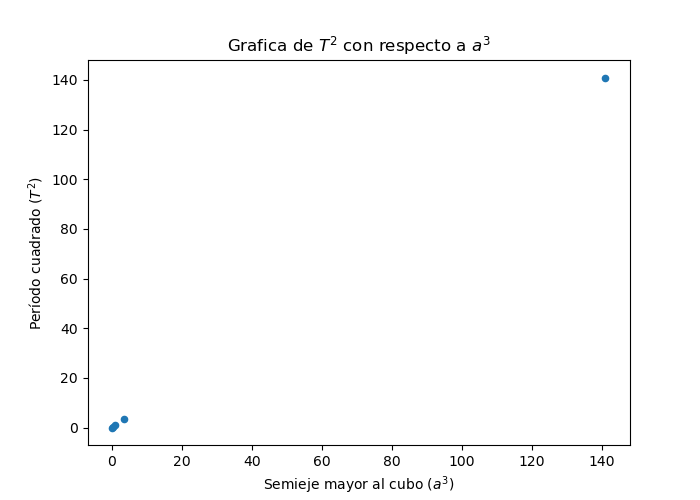

In [99]:
figS = plt.figure(figsize = (7,5))

plt.title(r"Grafica de $T^2$ con respecto a $a^3$")  
plt.ylabel(r"Período cuadrado ($T^2$)")
plt.xlabel(r"Semieje mayor al cubo ($a^3$)")
plt.scatter(cbd_a,sqrd_T,s=20)

**d.** Usando el curso de métodos I, haga una regresión lineal para encontrar la pendiente y punto de corte de la regresión.

In [100]:
def GetRegression(x,y):
    mean_y = np.mean(y)
    mean_x = np.mean(x)
    p = np.sum((x-mean_x)*(y-mean_y))
    q = np.sum((x-mean_x)**2)
    m = p/q
    b = mean_y - m*mean_x
    return m,b

m,b = GetRegression(cbd_a,sqrd_T)
print("Pendiente de: %s \nPunto de corte: %s"%(m,b))

Pendiente de: 0.9999271439656255 
Punto de corte: 0.00024784099935715176


**e.** Con el valor de la pendiente, reporte la masa del Sol en unidades gausianas y en el sistema internacional.

Teniendo en cuenta que el período de un planeta se puede describir como $$T^2 = \frac{4\pi^2}{GM_{\odot}}a^3$$ que en unidades guasianas está dado por $$T^2 = M_{\odot}^{-1}a^3.$$ Por lo que, dado que ya se tiene la razón $\frac{T^2}{a^3}$, entonces la pendiente $m$ será el inverso de la masa solar. Esto es:

In [101]:
solar_mass_gauss = 1/m
solar_mass_IS = solar_mass_gauss*(1.989e30)
print(r"Masa solar en unidades gausianas: %s masas solares."%(round(solar_mass_gauss,5)))
print(r"Masa solar en unidades internacionales: %s kg."%(solar_mass_IS))

Masa solar en unidades gausianas: 1.00007 masas solares.
Masa solar en unidades internacionales: 1.9891449212107556e+30 kg.


Simulación de los planetas:

<IPython.core.display.Javascript object>


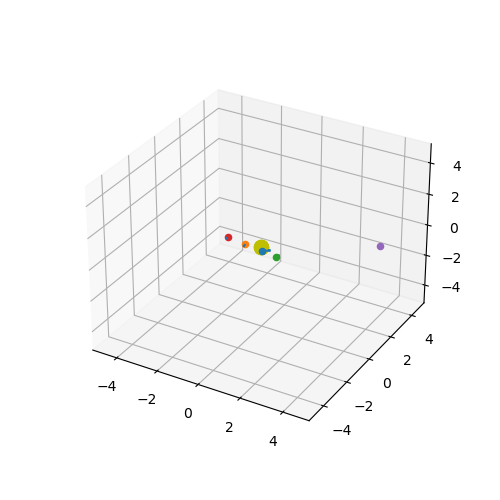

In [102]:
scale = 20
t1 = t[::scale]
figH = plt.figure(figsize=(5,5))
axH = figH.add_subplot(projection='3d')


def init_():
    
    axH.clear()
    axH.set_xlim(-5,5)
    axH.set_ylim(-5,5)
    axH.set_zlim(-5,5)
    
    
def Update_(i):
    
    init_()
    
    for j, p in enumerate(Planetas):
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        z = p.GetPosition(scale)[i,2]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        vz = p.GetVelocity(scale)[i,2]
    
        axH.scatter(0,0,0,s=100,color='y')
        axH.quiver(x,y,z,vx,vy,vz,length=0.03)
        
        axH.scatter(x,y,z)
        
        circle = plt.Circle((x,y),0.1,fill=True)

        
    
AnimationFG = anim.FuncAnimation(figH,Update_,frames=len(t1),init_func=init_)

***

**8.** Considere la ecuación diferencial $$ \frac{\text{d}u}{\text{d}t} = \alpha u ,\, u(0)=u_0.$$ 

Muestre que aplicando iterativamente se obtiene:

$$u_k = (1+\alpha \Delta t)^k u_0$$ 

Para el caso en que $\alpha < 0$. Muestre que la solución numérica oscilará si $\Delta t > -\frac{1}{\alpha}$.

> **Solución:**

Teniendo en cuenta el método de Euler, se sabe que 

$$u_{i+1} = u_{i} + \Delta t (\alpha u_{i})$$

Se puede reescribir como 

$$u_{k} = (1 + \alpha \Delta t) \cdot u_{k-1}.$$ 

Sin embargo, se tiene, por la segunda igualdad que 

$$u_{k} = (1 + \alpha\Delta t)^2 \cdot u_{k-2}$$ 

Usando estos pasos de manera iterada $k-1$ veces, se obtiene que 

$$u_k = (1 + \alpha\Delta t)^k \cdot u_0.$$

Por otro lado, usando el hecho de que $\alpha < 0$. Se puede llegar a que 

$$ \alpha \Delta t < -1 $$ 

Sumando uno a ambos lados 

$$ 1 + \alpha t < 0 $$ 

Esto significa que la expresión $(1 + \alpha \Delta t)^k$ será positiva o negativa dependiendo de si $k$ es par o impar, respectivamente.

Ajuste $\alpha = -1$ y muestre las soluciones oscilatorias para $\Delta t = 1.1, 1.5 \text{ y } 1.9 \text{ s}$. Por otro lado, la solución exacta nunca oscila $u(t) = e^{\alpha t}$.

> **Solución:**

<IPython.core.display.Javascript object>


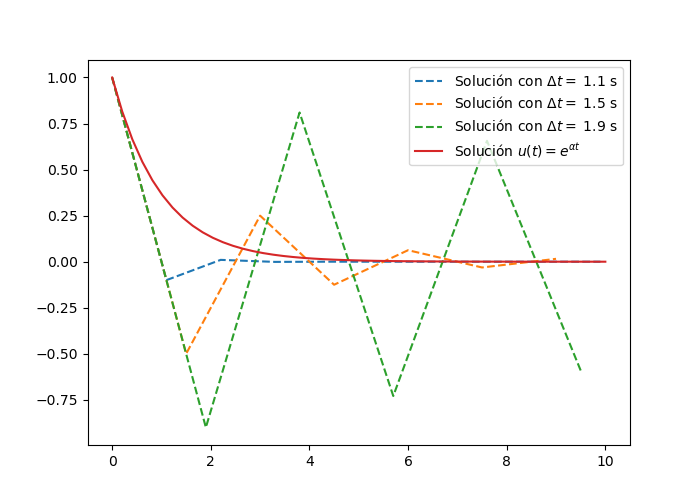

In [104]:
dt = [1.1,1.5,1.9]
N = 100
alpha = -1
u = [np.zeros(N),np.zeros(N),np.zeros(N)]

figF = plt.figure(figsize = (7, 5))
ax = figF.add_subplot(1,1,1)

for j in range(len(dt)):
    for i in range(N-1):
        if i == 0:
            u[j][i] = 1
        u[j][i+1] = (1 + alpha*dt[j])*u[j][i]
    t = np.arange(0,10,dt[j])
    ax.plot(t,u[j][:len(t)],label=r"Solución con $\Delta t =$ %s s"%(dt[j]),linestyle="dashed")
tlins = np.linspace(0,10)
ax.plot(tlins,np.exp(alpha*tlins),label=r"Solución $u(t) = e^{\alpha t}$")

plt.legend()